In [1]:
from google.colab import drive
drive.mount('/content/gdrive') #, force_remount=True

Mounted at /content/gdrive


In [1]:
import os
os.chdir('gdrive/My Drive/Colab Notebooks/nlp_hw')

In [3]:
!pip install pandas scikit-learn gensim matplotlib

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

Для наглядности возьмем две разные задачи - классификации и регресии. В обоих задачах мы будем работать с текстом и по большей части весь пайплайн у нас будет одинаков. Отличаться будут только последние штрихи в самих моделях.

In [3]:
import pandas as pd
import numpy as np
from string import punctuation
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from collections import Counter
import matplotlib.pyplot as plt
%matplotlib inline

Данные возьмем из соревнования - https://www.kaggle.com/c/quora-insincere-questions-classification/overview  
В этом соревновании нужно было предсказывать токсичность вопроса.

In [4]:
quora = pd.read_csv('quora.csv')

In [5]:
quora.head()

,qid,question_text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0


Предобработка

In [6]:
def preprocess(text):
    tokens = text.lower().split()
    tokens = [token.strip(punctuation) for token in tokens]
    return tokens

In [7]:
# словарь
vocab = Counter()

for text in quora.question_text:
    vocab.update(preprocess(text))

In [8]:
len(vocab)

273056

In [9]:
# отфильтрованный словарь
filtered_vocab = set()

for word in vocab:
    if vocab[word] > 50:
        filtered_vocab.add(word)

In [10]:
len(filtered_vocab)

14083

In [11]:
# индексируем слова
word2id = {'PAD':0}

for word in filtered_vocab:
    word2id[word] = len(word2id)

In [12]:
id2word = {i:word for word, i in word2id.items()}

In [13]:
# поставить тоже 100
MAX_LEN = 100

In [14]:
class Dataset(torch.utils.data.Dataset):

    def __init__(self, dataset, word2id, MAX_LEN, text_field, target_field):
        
        # храним сырой датасет
        self.dataset = dataset[text_field].values
        
        self.word2id = word2id
        self.MAX_LEN = MAX_LEN
        self.length = dataset.shape[0]
        self.target = torch.Tensor(dataset[target_field].values)

    def __len__(self):
        return self.length

    def __getitem__(self, index):

        tokens = self.preprocess(self.dataset[index]) #токенизируем
        ids = [self.word2id[token] for token in tokens if token in self.word2id][:MAX_LEN]
        ids = torch.nn.functional.pad(torch.LongTensor(ids), 
                                (0, self.MAX_LEN-len(ids)), 
                                mode='constant',
                                value=0)
        y = self.target[index]
        return ids, y
    
    def preprocess(self, text):
        tokens = text.lower().split()
        tokens = [token.strip(punctuation) for token in tokens]
        tokens = [token for token in tokens if token]
        return tokens

In [15]:
random_seed = 46

In [16]:
train_dataset, valid_dataset = train_test_split(quora, test_size=0.05, random_state = random_seed)

In [17]:
training_set = Dataset(train_dataset, word2id, MAX_LEN, 'question_text', 'target')
training_generator = torch.utils.data.DataLoader(training_set, batch_size=256)

valid_set = Dataset(valid_dataset, word2id, MAX_LEN, 'question_text', 'target')
valid_generator = torch.utils.data.DataLoader(valid_set, batch_size=256)

## Задача 1

1) На одной из задач сравните, что лучше: а) конкатенировать эмбединги в один большой эмбединг, б) усреднять эмбединги, в) складывать эмбединги. Зафиксируйте разбиение на train_test  через random_seed, чтобы обучаться и оцениваться на одних и тех же данных. Параметры нейронок не нужно делать одинаковыми. Просто попробуйте добиться максимума от каждого из подходов. 

### а) конкатенировать эмбединги в один большой эмбединг

In [27]:
class Clf(nn.Module):
    
    def __init__(self, vocab_size, embedding_dim, output_dim):
        
        super().__init__()          
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.flatten = nn.Flatten() # вместо усреднения склеим все в 1 вектор
        self.fc = nn.Linear(embedding_dim*MAX_LEN, output_dim)
        self.act = nn.Sigmoid()
        
    def forward(self, text):
        
        embedded = self.embedding(text)   
        hidden = self.flatten(embedded)
        dense_outputs=self.fc(hidden)
        outputs=self.act(dense_outputs)
        
        return outputs

In [18]:
def binary_accuracy(preds, y):
    rounded_preds = torch.round(preds)
    
    correct = (rounded_preds == y).float() 
    acc = correct.sum() / len(correct)
    return acc


def train(model, iterator, optimizer, criterion, print_every=1000):
    
    epoch_loss = 0
    epoch_acc = 0
    model.train()  

    for i, (texts, ys) in enumerate(iterator):
        
        optimizer.zero_grad()   
        predictions = model(texts.to(device)).squeeze()  
        loss = criterion(predictions.float(), ys.to(device).float())        
        acc = binary_accuracy(predictions.float(), ys.to(device).float())
        loss.backward()     
        
        optimizer.step()      
        
        epoch_loss += loss.item()  
        epoch_acc += acc.item()
        
        if not (i+1) % print_every:
            print(f'Loss: {epoch_loss/i}; Accuracy: {epoch_acc/i}')
        
    return epoch_acc / len(iterator)


def evaluate(model, iterator, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()  
    with torch.no_grad():
        for texts, ys in iterator:   

            predictions = model(texts.to(device)).squeeze()  
            loss = criterion(predictions.float(), ys.to(device).float())        
            acc = binary_accuracy(predictions.float(), ys.to(device).float())

            epoch_loss += loss.item()  
            epoch_acc += acc.item()
            
    return epoch_acc / len(iterator)

In [ ]:
import torch.optim as optim

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  
model = Clf(len(word2id), 30, 1)

optimizer = optim.Adam(model.parameters())
criterion = nn.BCELoss() # другой лосс - Binary cross-entropy

model = model.to(device)
criterion = criterion.to(device)

In [30]:
accs = []
accs_eval = []
for i in range(3):
    print(i)
    accs.append(train(model, training_generator, optimizer, criterion))
    accs_eval.append(evaluate(model, valid_generator, criterion))

0
Loss: 0.1886339020785746; Accuracy: 0.9392556619119119
Loss: 0.17156058119953782; Accuracy: 0.9420569659829915
Loss: 0.16137136060715954; Accuracy: 0.9439696044514838
Loss: 0.15513600190488003; Accuracy: 0.9451884455488873
1
Loss: 0.126933716431454; Accuracy: 0.9530350663163163
Loss: 0.12602592717526315; Accuracy: 0.9529315438969485
Loss: 0.12435982635082624; Accuracy: 0.9529921432144048
Loss: 0.12397938541030251; Accuracy: 0.952971641347837
2
Loss: 0.11934536538115731; Accuracy: 0.9552208458458459
Loss: 0.11920063817997525; Accuracy: 0.9549755346423212
Loss: 0.11809404718553912; Accuracy: 0.9548886087029009
Loss: 0.1181933971508037; Accuracy: 0.9546878907226807


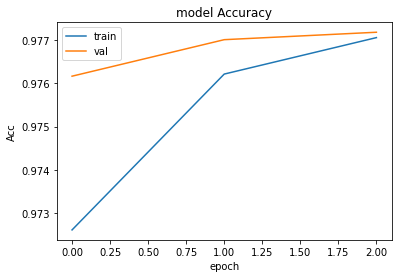

In [31]:
plt.plot(np.sqrt(accs))
plt.plot(np.sqrt(accs_eval))
plt.title('model Accuracy')
plt.ylabel('Acc')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [35]:
preds = []
targets = []
for texts, ys in valid_generator:
    preds += model(texts.to(device)).squeeze().detach().to('cpu').numpy().tolist()
    targets += ys.numpy().tolist()

In [36]:
print(classification_report(targets, (np.array(preds) > 0.5).astype(int)))

              precision    recall  f1-score   support

         0.0       0.97      0.98      0.98     61373
         1.0       0.67      0.49      0.57      3934

    accuracy                           0.95     65307
   macro avg       0.82      0.74      0.77     65307
weighted avg       0.95      0.95      0.95     65307



### б) усреднять эмбединги

In [40]:
class Clf(nn.Module):
    
    def __init__(self, vocab_size, embedding_dim, output_dim):
        
        super().__init__()          
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.fc = nn.Linear(embedding_dim, output_dim)
        self.act = nn.Sigmoid()
        
    def forward(self, text):
        
        embedded = self.embedding(text)   
        hidden = torch.mean(embedded, dim=1) #усредняем вектора
        dense_outputs=self.fc(hidden)
        outputs=self.act(dense_outputs)
        
        return outputs

In [41]:
model = Clf(len(word2id), 30, 1)

optimizer = optim.Adam(model.parameters())
criterion = nn.BCELoss()

model = model.to(device)
criterion = criterion.to(device)

In [42]:
accs = []
accs_eval = []
for i in range(3):
    print(i)
    accs.append(train(model, training_generator, optimizer, criterion))
    accs_eval.append(evaluate(model, valid_generator, criterion))

0
Loss: 0.23814091014790464; Accuracy: 0.9384736298798799
Loss: 0.221699315713548; Accuracy: 0.9384868215357679
Loss: 0.2069908690928578; Accuracy: 0.9390031052017339
Loss: 0.19541396586320853; Accuracy: 0.9398873155788947
1
Loss: 0.14636825177225624; Accuracy: 0.9470564314314315
Loss: 0.14397146265810284; Accuracy: 0.9473428120310156
Loss: 0.1416457576137477; Accuracy: 0.9476843843781261
Loss: 0.14036285029419157; Accuracy: 0.9478394989372343
2
Loss: 0.13149606919026113; Accuracy: 0.9508766579079079
Loss: 0.1310089384040247; Accuracy: 0.9509461762131065
Loss: 0.1297881286386332; Accuracy: 0.9510018964654885
Loss: 0.12956583466838228; Accuracy: 0.9508177825706426


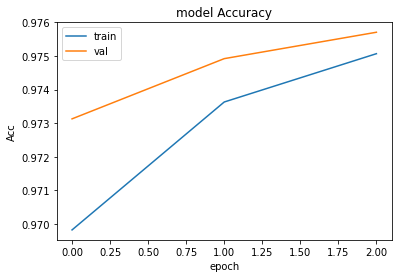

In [43]:
plt.plot(np.sqrt(accs))
plt.plot(np.sqrt(accs_eval))
plt.title('model Accuracy')
plt.ylabel('Acc')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [44]:
preds = []
targets = []
for texts, ys in valid_generator:
    preds += model(texts.to(device)).squeeze().detach().to('cpu').numpy().tolist()
    targets += ys.numpy().tolist()

print(classification_report(targets, (np.array(preds) > 0.5).astype(int)))

              precision    recall  f1-score   support

         0.0       0.96      0.99      0.97     61373
         1.0       0.69      0.37      0.48      3934

    accuracy                           0.95     65307
   macro avg       0.82      0.68      0.73     65307
weighted avg       0.94      0.95      0.95     65307



При усреднении результаты получились немного похуже: лосс итоговый побольше, точность похуже, и на графике видно, что рост accuracy медленнее

### в) складывать эмбединги

In [46]:
class Clf(nn.Module):
    
    def __init__(self, vocab_size, embedding_dim, output_dim):
        
        super().__init__()          
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.fc = nn.Linear(embedding_dim, output_dim)
        self.act = nn.Sigmoid()
        
    def forward(self, text):
        
        embedded = self.embedding(text)   
        hidden = torch.sum(embedded, dim=1) #суммируем вектора
        dense_outputs=self.fc(hidden)
        outputs=self.act(dense_outputs)
        
        return outputs

In [47]:
model = Clf(len(word2id), 30, 1)

optimizer = optim.Adam(model.parameters())
criterion = nn.BCELoss()

model = model.to(device)
criterion = criterion.to(device)

In [48]:
accs = []
accs_eval = []
for i in range(3):
    print(i)
    accs.append(train(model, training_generator, optimizer, criterion))
    accs_eval.append(evaluate(model, valid_generator, criterion))

0
Loss: 0.20583842594821652; Accuracy: 0.9367140578078078
Loss: 0.18157472034330185; Accuracy: 0.9409685311405703
Loss: 0.16910413493038653; Accuracy: 0.9432284719906635
Loss: 0.1618591372923244; Accuracy: 0.9446072455613903
1
Loss: 0.13019438884831644; Accuracy: 0.9522647647647647
Loss: 0.13021395513867068; Accuracy: 0.952126453851926
Loss: 0.1287396622808646; Accuracy: 0.9523526071190397
Loss: 0.1286130055550427; Accuracy: 0.9522312218679669
2
Loss: 0.12418637739809545; Accuracy: 0.9540086961961962
Loss: 0.12492263984827771; Accuracy: 0.9536252501250625
Loss: 0.12377987164543167; Accuracy: 0.95374109078026
Loss: 0.12405286443255102; Accuracy: 0.9535215835208802


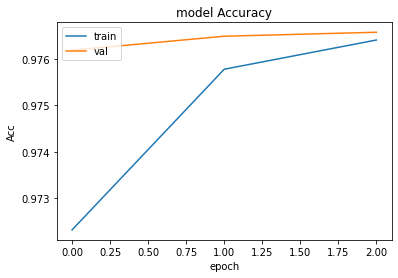

In [49]:
plt.plot(np.sqrt(accs))
plt.plot(np.sqrt(accs_eval))
plt.title('model Accuracy')
plt.ylabel('Acc')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [50]:
preds = []
targets = []
for texts, ys in valid_generator:
    preds += model(texts.to(device)).squeeze().detach().to('cpu').numpy().tolist()
    targets += ys.numpy().tolist()

print(classification_report(targets, (np.array(preds) > 0.5).astype(int)))

              precision    recall  f1-score   support

         0.0       0.96      0.99      0.98     61373
         1.0       0.68      0.44      0.53      3934

    accuracy                           0.95     65307
   macro avg       0.82      0.71      0.75     65307
weighted avg       0.95      0.95      0.95     65307



Здесь accuracy стала лучше, чем при усреднении, результаты примерно как при склеивании. Что касается лосса, он уменьшается быстрее, чем при усреднении, но медленнее, чем при склеивании.

## Задача 2

2) В одной из задач используйте сразу две предобученные эмбединг модели (можно фастекст и ворд2век, а можно просто 2 фастекста с разными параметрами) в одной нейронке (имеется в виду предобученные до обучения нейронки, т.е вы можете сами обучить фастекст/ворд2век и не искать готовые модели в интернете). Попробуйте усреднять эмбединги и конкатенировать (общие эмбединги потом в один вектор собирайте любым способом - например, тем который оказался лучше в первой задаче).
Подсказка: сделайте два Embedding слоя и к их выходам примените torch.cat(dim=2) или torch.mean(dim=2)

Бонусный балл можно получить за добавление к пайплайну subword токенизации (через библиотеку tokenizers например)

In [19]:
import gensim

In [20]:
#тексты из датасета для обучения эмбеддинг моделей
train_texts = train_dataset.question_text.apply(preprocess).tolist()

In [22]:
emb_dim = 30

In [24]:
w2v = gensim.models.Word2Vec(train_texts, size=emb_dim)

In [25]:
ft = gensim.models.FastText(train_texts, size=emb_dim)

In [26]:
w2v_weights = np.zeros((len(word2id), emb_dim))
ft_weights = np.zeros((len(word2id), emb_dim))

In [33]:
def get_embeddings(model_weigths, model):
  for word, i in word2id.items():
    if word == 'PAD':
      continue  
    try:
      model_weigths[i] = model.wv[word]
    except KeyError:
      err = True
      while err == True:
        try:
          random_word = np.random.choice(word2id.keys())
          random_weight = model.wv[random_word]
          err = False
        except:
          err = True
      weights[i] = random_weight
  
  return model_weigths

In [34]:
w2v_weights = get_embeddings(w2v_weights, w2v)

In [35]:
ft_weights = get_embeddings(ft_weights, ft)

In [37]:
w2v_weights[1][:10]

array([-1.62669599, -1.9430939 , -1.75248933,  0.04018322,  1.03790796,
        0.61497086, -0.82123923, -0.96534997,  0.57787365,  2.7261405 ])

In [45]:
class Clf(nn.Module):
    
    def __init__(self, vocab_size, embedding_dim, output_dim, embs_w2v, embs_ft):
        
        super().__init__()
        self.embedding_1 = nn.Embedding(vocab_size, embedding_dim)          
        self.embedding_2 = nn.Embedding(vocab_size, embedding_dim)

        self.embedding_1.from_pretrained(torch.tensor(embs_w2v), freeze=True)
        self.embedding_2.from_pretrained(torch.tensor(embs_ft), freeze=True)

        self.fc = nn.Linear(embedding_dim*2, output_dim)
        self.act = nn.Sigmoid() 
        
    def forward(self, text):
        
        embedded_w2v = self.embedding_1(text)   
        hidden_w2v = torch.mean(embedded_w2v, dim=1)

        embedded_ft = self.embedding_2(text)   
        hidden_ft = torch.mean(embedded_ft, dim=1)

        hidden_final = torch.cat((hidden_w2v, hidden_ft), dim=1)
        
        dense_outputs = self.fc(hidden_final)
        outputs=self.act(dense_outputs)
        
        return outputs

In [46]:
import torch.optim as optim

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  
model = Clf(len(word2id), 30, 1, w2v_weights, ft_weights)

optimizer = optim.Adam(model.parameters())
criterion = nn.BCELoss()

model = model.to(device)
criterion = criterion.to(device)

In [47]:
accs = []
accs_eval = []
for i in range(3):
    print(i)
    accs.append(train(model, training_generator, optimizer, criterion))
    accs_eval.append(evaluate(model, valid_generator, criterion))

0
Loss: 0.24104923003160203; Accuracy: 0.9284323385885885
Loss: 0.21936043057070784; Accuracy: 0.9336015664082041
Loss: 0.20223261110631177; Accuracy: 0.9362039950816939
Loss: 0.19021849773934138; Accuracy: 0.9380743623405852
1
Loss: 0.14093831204646104; Accuracy: 0.9480808933933934
Loss: 0.1387973315622462; Accuracy: 0.9485133191595798
Loss: 0.13663675488233964; Accuracy: 0.9489165659386463
Loss: 0.13556601621898062; Accuracy: 0.9490185046261566
2
Loss: 0.12814593366212076; Accuracy: 0.9518463776276276
Loss: 0.12778109089173692; Accuracy: 0.9518724205852926
Loss: 0.12660539463763637; Accuracy: 0.951860255501834
Loss: 0.1264586007736286; Accuracy: 0.9517252359964992


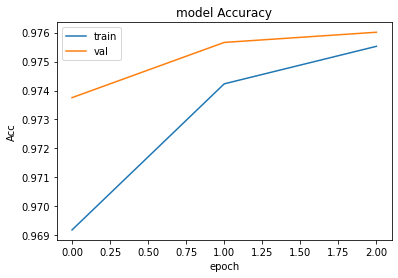

In [48]:
plt.plot(np.sqrt(accs))
plt.plot(np.sqrt(accs_eval))
plt.title('model Accuracy')
plt.ylabel('Acc')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [49]:
preds = []
targets = []
for texts, ys in valid_generator:
    preds += model(texts.to(device)).squeeze().detach().to('cpu').numpy().tolist()
    targets += ys.numpy().tolist()

print(classification_report(targets, (np.array(preds) > 0.5).astype(int)))

              precision    recall  f1-score   support

         0.0       0.96      0.99      0.98     61373
         1.0       0.69      0.39      0.50      3934

    accuracy                           0.95     65307
   macro avg       0.82      0.69      0.74     65307
weighted avg       0.95      0.95      0.95     65307

